## Imports 

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

In [6]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index("Date").dropna(axis = 0)

### Feature selection 

In [19]:
our_features= ['PX_OPEN_VIX_volatility', 'VOLUME_TOTAL_CALL_VIX_volatility',
       'PUT_CALL_VOLUME_RATIO_CUR_DAY_SPX_volatility',
       'VOLUME_TOTAL_PUT_SPX_volatility', 'VOLATILITY_30D_SPX_volatility',
       'VOLATILITY_20D_SPX_volatility', 'VOLATILITY_30D_SX5E_volatility',
       'VOLATILITY_90D_SX5E_volatility', 'VOLATILITY_60D_SX5E_volatility',
       'VOLATILITY_20D_SX5E_volatility', 'PX_OPEN_VSTOXX_volatility',
       'PX_LOW_VSTOXX_volatility', 'QMJ USA_QMJ Factors',
       'QMJ Global_QMJ Factors', 'BAB USA_BAB Factors',
       'BAB Global_BAB Factors', 'Bullish_SENTIMENT',
       'Bullish 8-week Mov Avg_SENTIMENT', 'Bull-Bear Spread_SENTIMENT',
       'Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily',
       'SMB_F-F_Research_Data_5_Factors_2x3_daily',
       'CMA_F-F_Research_Data_5_Factors_2x3_daily']

### Train/Test split

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

prescale_X = df[our_features]
y = df[["Box"]]
#x = (prescale_X - prescale_X.mean())/prescale_X.std()

X_train, X_test, y_train, y_test = train_test_split(prescale_X, y, test_size=0.2)


# 1) Random Forest 

### All the possible parameters 

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Using a randomized grid search 

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


### Training 

In [23]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
final_model = rf_random.best_estimator_

In [29]:
y_pred= final_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       246
           1       0.70      0.58      0.63       238

    accuracy                           0.67       484
   macro avg       0.68      0.67      0.67       484
weighted avg       0.68      0.67      0.67       484



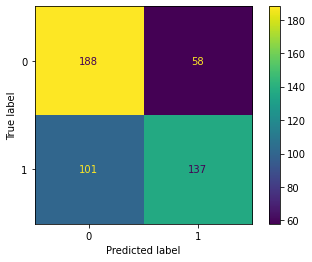

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(estimator=final_model, X=X_test, y=y_test)

# Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier 

In [31]:
tree_clf= DecisionTreeClassifier(max_depth= 15)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15)

In [35]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
               out_file= "tree.dot",
               feature_names= our_features,
               rounded= True,
               filled= True)